# Imports, styles, etc

In [3]:
import numpy as np
import pandas as pd
from liwc import Liwc
from matplotlib import pyplot as plt
import seaborn as sns
import json
from tqdm import tqdm
import scipy
import glob
import re
import yaml
import warnings
warnings.filterwarnings("ignore")
tqdm.pandas()

import scipy.stats as stats

filepaths = yaml.safe_load(open("../../../config/filepaths.yaml"))

import sys
sys.path.append(filepaths['utils'])
from data import *
from liwc_utils import *
from analisys import *

In [4]:
plt.rcParams['axes.labelsize']  = 14 # fontes no tamanho usado no template
plt.rcParams['axes.titlesize']  = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['font.family'] = 'serif'
# plt.rcParams['text.usetex'] = True
plt.rcParams['lines.linewidth'] = 1.5

plt.style.use('tableau-colorblind10') # use um estilo colorblind!
plt.ion()

---

In [5]:
DATASET = 'interview' # 'coraal-buckeye' | 'twitter' | 'youtube' | 'interview'

data = load_dataset(DATASET)
data.head(1)

,text,perspective_score,flair_score,textblob_score,vader_score,file,group
0,They are taxpayer-owned entities.,0.028611,0.156813,0.444444,0.0,white-f-gretchen morgenson,White Woman


In [6]:
#Numero de amostras de cada tipo
data.drop_duplicates('file').groupby('group').count()['text']

group
Black Man      44
Black Woman    40
White Man      43
White Woman    43
Name: text, dtype: int64

# Reading and processing data

In [7]:
# Faz copia dos dados e remove qualquer caracter que não seja textual ou apóstrofo
df = data.copy()
df['text'] = df['text'].apply(lambda x: re.sub("[^\w\d'\s]+",'',x))

In [8]:
df.loc[df.group.isin(['Black Woman', 'Black Man']),'group'] = 'AA'
df.loc[df.group.isin(['White Woman', 'White Man']),'group'] = 'WH'
df.drop_duplicates('file').groupby('group').count()['text']

group
AA    84
WH    86
Name: text, dtype: int64

In [9]:
# executes a join in column text grouped by file, this will join all the texts and keep group info
text_df = df.groupby('file',as_index=False).agg({
    'text': lambda x: ' '.join(x),
    'group': lambda x: x.iloc[0]
})
text_df.head(3)

,file,text,group
0,black-f-alexis mcgill johnson,Implicit bias is our brains' automatic process...,AA
1,black-f-alondra nelson,As a very young girl it became clear that I wa...,AA
2,black-f-alysia montano,We're not paid a huge salary by a league at al...,AA


In [10]:
# carrega o dicionário e inicializa a classe do LIWC
liwc_parser = Liwc(filepaths['liwc_dict']) 

#aplica do liwc
text_df['liwc_count'] = text_df['text'].apply(liwc_sentence_parse, args=(liwc_parser,)) 
text_df = text_df.reset_index(drop=True)
text_df.head(3)

,file,text,group,liwc_count
0,black-f-alexis mcgill johnson,Implicit bias is our brains' automatic process...,AA,"{'function': 230, 'auxverb': 47, 'verb': 77, '..."
1,black-f-alondra nelson,As a very young girl it became clear that I wa...,AA,"{'function': 467, 'article': 67, 'adverb': 42,..."
2,black-f-alysia montano,We're not paid a huge salary by a league at al...,AA,"{'function': 333, 'negate': 11, 'cogproc': 60,..."


---

# Processing data with LIWC

In [11]:
# create a new dataset where the dicts inside liwc_cont are expanded in columns
liwc_df = pd.concat([text_df.drop(['liwc_count'], axis=1), text_df['liwc_count'].apply(pd.Series)], axis=1)
liwc_df = liwc_df.fillna(0)

#normalizing
liwc_df_norm = (liwc_df[liwc_parser.categories.values()].T * ( 1 / liwc_df[liwc_parser.categories.values()].sum(axis=1) )).T
liwc_df_norm.reset_index(drop=True,inplace=True)

liwc_df_norm['group'] = text_df['group']
liwc_df_norm = liwc_df_norm.fillna(0)
liwc_df_norm.head(3)

,function,pronoun,ppron,i,we,you,shehe,they,ipron,article,...,money,relig,death,informal,swear,netspeak,assent,nonflu,filler,group
0,0.181675,0.060032,0.033965,0.000790,0.022907,0.007109,0.000000,0.003160,0.026066,0.016588,...,0.000790,0.000000,0.0,0.001580,0.0,0.0,0.001580,0.000000,0.0,AA
1,0.195316,0.051861,0.027185,0.006692,0.002509,0.007528,0.006692,0.003764,0.024676,0.028022,...,0.001255,0.000836,0.0,0.000836,0.0,0.0,0.000000,0.000836,0.0,AA
2,0.194509,0.052570,0.028037,0.008178,0.005257,0.007593,0.004673,0.002336,0.024533,0.020444,...,0.004089,0.000000,0.0,0.001168,0.0,0.0,0.000584,0.000000,0.0,AA


---

## Kruscal-Wallis Test

In [16]:
experiments = []
old_experiments = []

for feature in liwc_parser.categories.values():
    
    result = stats.kruskal(
        liwc_df_norm[liwc_df_norm.group=='AA'][feature],
        liwc_df_norm[liwc_df_norm.group=='WH'][feature]
    )
    experiments.append({
        'feature': feature,
        'statistic': result[0],
        'pvalue': result[1]
    })
experiments = pd.DataFrame(experiments)

## Relevant features

https://www.liwc.net/LIWC2007LanguageManual.pdf

https://repositories.lib.utexas.edu/bitstream/handle/2152/31333/LIWC2015_LanguageManual.pdf

In [17]:
import statsmodels.stats.multitest as smt
idx = smt.multipletests(pvals=experiments.pvalue, alpha=0.01, method="bonferroni")[0]
print(len(experiments[idx].sort_values('pvalue')))
experiments[idx].sort_values('pvalue')

0


,feature,statistic,pvalue


In [18]:
experiments[experiments.pvalue<0.01].sort_values('pvalue')

,feature,statistic,pvalue
3,i,10.732464,0.001053
39,percept,10.126489,0.001462
19,number,9.723899,0.001819
63,home,8.932643,0.002801
28,family,8.415832,0.003720


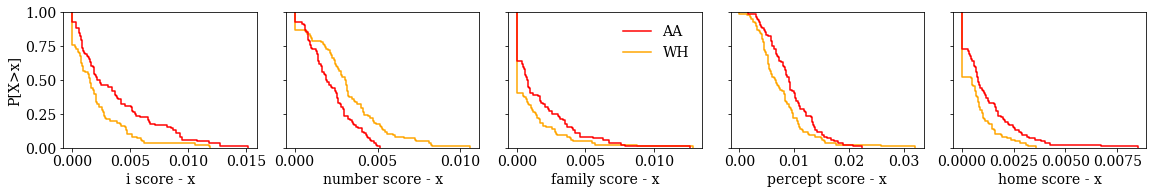

In [20]:
plot_liwc_features(
    liwc_df_norm, 
    ploting_vars=experiments[experiments.pvalue<0.01].feature, 
    hue_order=['AA','WH'],
    legend_labels = ['AA', 'WH'],
    palette=['red','orange'], 
)

# individual categories analisys

### calculating liwc per sentence

In [21]:
scores_liwc = df.copy()

scores_liwc['liwc_count'] = scores_liwc['text'].apply(liwc_sentence_parse, args=(liwc_parser,)) #aplica do liwc
scores_liwc['len'] = scores_liwc.text.str.split(' ').str.len()
scores_liwc = scores_liwc.reset_index().rename(columns={'index':'sentence_id'})
scores_liwc = pd.concat([scores_liwc.drop(['liwc_count'], axis=1), scores_liwc['liwc_count'].apply(pd.Series)], axis=1)
scores_liwc = scores_liwc.fillna(0)
scores_liwc.head(1)

,sentence_id,text,perspective_score,flair_score,textblob_score,vader_score,file,group,len,function,...,health,death,i,anger,family,relig,female,friend,filler,swear
0,0,They are taxpayerowned entities,0.028611,0.156813,0.444444,0.0,white-f-gretchen morgenson,WH,4,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### KS test and bonferroni correction - For liwc categories scored

In [22]:
liwc_toxicity_experiments = []
for score in [col for col in scores_liwc.columns if 'score' in col]:
    for feature in liwc_parser.categories.values():
        if (len(scores_liwc[scores_liwc[feature]==0]) == 0 
                and len(scores_liwc[scores_liwc[feature]>0] == 0)):
            liwc_toxicity_experiments.append({
                'feature': feature,
                'statistic': np.nan,
                'pvalue': np.nan,
                'score': score
            })
        else:
            result = stats.ks_2samp(
                scores_liwc[scores_liwc[feature]==0][score],
                scores_liwc[scores_liwc[feature]>0][score]
            )
            liwc_toxicity_experiments.append({
                'feature': feature,
                'statistic': result[0],
                'pvalue': result[1],
                'score': score
            })

liwc_toxicity_experiments = pd.DataFrame(liwc_toxicity_experiments)
liwc_toxicity_experiments.sort_values('pvalue')

,feature,statistic,pvalue,score
32,cogproc,0.177451,0.000000e+00,perspective_score
105,cogproc,0.255768,0.000000e+00,flair_score
251,cogproc,0.169696,0.000000e+00,vader_score
240,affect,0.376103,6.370270e-212,vader_score
244,anger,0.733585,8.283878e-211,vader_score
...,...,...,...,...
216,assent,0.055711,8.371323e-01,textblob_score
286,informal,0.032647,9.441144e-01,vader_score
266,ingest,0.034914,9.841900e-01,vader_score
291,filler,0.266282,9.978896e-01,vader_score


In [23]:
#seleciona as categorias em que todos scores são estatisticamente diferentes (p-value < 0.01)
#TODO: Bonferroni correction

relevant_categories_by_toxicity = liwc_toxicity_experiments.iloc[
    liwc_toxicity_experiments.groupby('feature').agg({
        'pvalue': lambda x: x.idxmax(),
    })['pvalue']
].query('pvalue < 0.01').feature.unique()

relevant_categories_by_toxicity

array(['adj', 'adverb', 'affect', 'anger', 'anx', 'article', 'auxverb',
       'cause', 'certain', 'cogproc', 'compare', 'conj', 'death',
       'differ', 'drives', 'feel', 'focuspast', 'focuspresent',
       'function', 'insight', 'interrog', 'ipron', 'negate', 'negemo',
       'percept', 'posemo', 'power', 'ppron', 'prep', 'pronoun', 'quant',
       'relativ', 'risk', 'social', 'space', 'tentat', 'verb', 'you'],
      dtype=object)

In [25]:
experiments[(experiments.pvalue<0.01) & experiments.feature.isin(relevant_categories_by_toxicity) ]

,feature,statistic,pvalue
39,percept,10.126489,0.001462


---
# Associating categories frequencies with toxicity

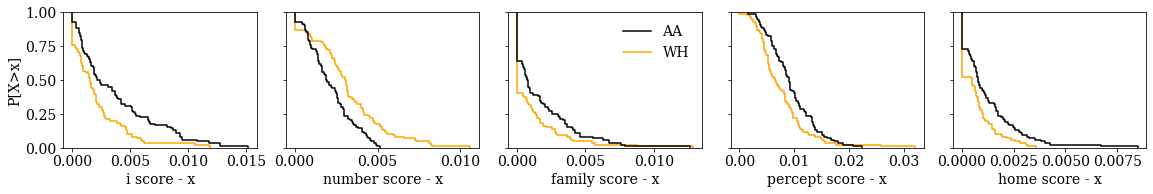

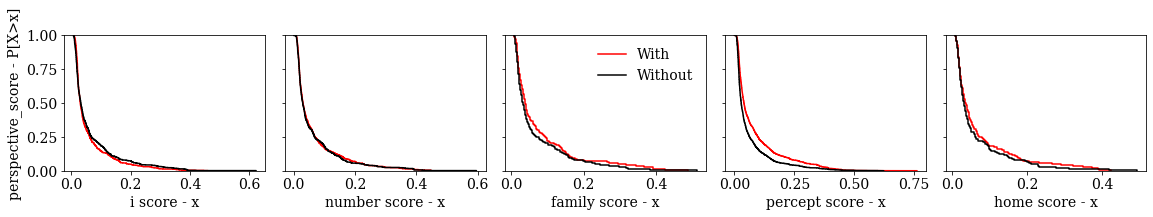

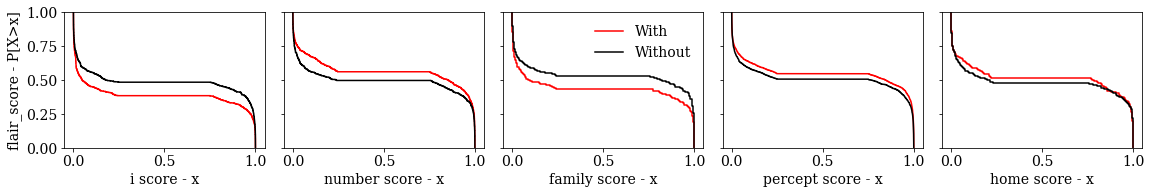

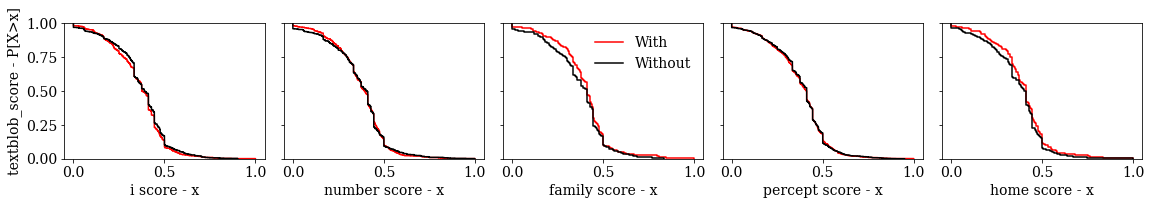

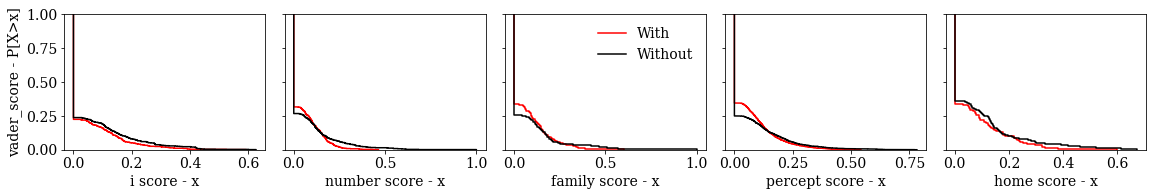

In [27]:
# TODO: nos graficos de score (with e without) usar distribuições com o 
# mesmo numero de sentenças de pretos e brancos, homem e mulher, no momento, 
# nenhuma das formas considera um numero de amostras igual por genero e raça


# analisa i a i de 5 em 5 categorias as categorias que são estatisticamente diferentes obtidas 
# na analise anterior e plota suas frequencias e seus scores
# i = 0
# i += 5
# ploting_vars = ['number','percept','i', 'verb', 'discrep','interrog','focusfuture']
# #list(experiments[experiments.feature.isin(relevant_categories_by_toxicity)].sort_values('pvalue').iloc[i:i+5].feature)

ploting_vars = experiments[experiments.pvalue<0.01].feature
plot_figsize = (16,2.8)

plot_liwc_features(
    liwc_df_norm, 
    ploting_vars=ploting_vars, 
    hue_order=['AA','WH'],
    legend_labels = ['AA', 'WH'],
    palette=['black','orange'], 
    plot_figsize=plot_figsize
)
plot_liwc_scored(
    scores_liwc,
    ploting_vars=ploting_vars, 
    scores=scores_liwc.columns,
    comparative_behaviour='same_sz_sample',
    plot_figsize=plot_figsize
)

# categorias interessantes: filler, tentat, affiliation, famale, you, motion, auxverb, quant, focuspast, ipron, percept, home, family, 
# differ, relativ, they, anger, drives, negemo, leisure, cogproc, risk, hear, affect, i, informal, anx, space, money, relig, spcial, sad,
# posemo, see, sexual, cause, friend, power, ingest, focousfuture, body, death, bio, feel

---

# Avg. words per video

In [26]:
scores_liwc.groupby(['file','group']).sum()[['len']].reset_index().groupby('group').mean()

,len
group,
AA,695.904762
WH,583.372093
